In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.layers import Add, ReLU, Conv2DTranspose, BatchNormalization, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
PATH = '/kaggle/input/utkface-new/UTKFace'

In [13]:
image_paths = []
age_labels = []

for filename in os.listdir(PATH):
    image_path = os.path.join(PATH, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

In [14]:
image_paths = np.array(image_paths)
age_labels = np.array(age_labels)

In [15]:
low_res_images = []
high_res_images = []

for image_path in image_paths:
    img = load_img(image_path, target_size=(128, 128))
    img_array_high = img_to_array(img)
    
    img_low_res = load_img(image_path, target_size=(32, 32))
    img_array_low = img_to_array(img_low_res)
    
    high_res_images.append(img_array_high)
    low_res_images.append(img_array_low)

In [16]:
low_res_images = np.array(low_res_images) / 255.0
high_res_images = np.array(high_res_images) / 255.0

In [17]:
X_train_lr, X_testval_lr, y_train_hr, y_testval_hr, age_labels_train, age_labels_testval = train_test_split(
    low_res_images, high_res_images, age_labels, test_size=0.2, random_state=42
)
X_val_lr, X_test_lr, y_val_hr, y_test_hr, age_labels_val, age_labels_test = train_test_split(
    X_testval_lr, y_testval_hr, age_labels_testval, test_size=0.5, random_state=42
)

In [21]:
# Custom PixelShuffle layer
class PixelShuffle(Layer):
    def __init__(self, scale, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config

In [22]:
# Define EDSR residual block
def edsr_residual_block(x, filters, scaling_factor=0.1):
    tmp = Conv2D(filters, kernel_size=3, padding='same')(x)
    tmp = ReLU()(tmp)
    tmp = Conv2D(filters, kernel_size=3, padding='same')(tmp)
    tmp = Add()([x, tmp * scaling_factor])
    return tmp

In [23]:
# Define pixel shuffle layer (sub-pixel convolution)
def pixel_shuffle(scale):
    def _pixel_shuffle(x):
        batch_size, h, w, c = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        channels = c // (scale * scale)
        x = tf.reshape(x, (batch_size, h, w, scale, scale, channels))
        x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
        x = tf.reshape(x, (batch_size, h * scale, w * scale, channels))
        return x
    return _pixel_shuffle

In [24]:
# Create EDSR model
def create_edsr(input_shape, num_filters=64, num_residual_blocks=16, scaling_factor=0.1):
    inputs = Input(shape=input_shape)
    
    # Initial feature extraction
    x = Conv2D(num_filters, kernel_size=3, padding='same')(inputs)
    conv1 = x
    
    # Residual blocks
    for _ in range(num_residual_blocks):
        x = edsr_residual_block(x, num_filters, scaling_factor)
    
    # Add back the first convolution layer's output
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = Add()([conv1, x])
    
    # Upsampling (32x32 -> 64x64 -> 128x128)
    for _ in range(2):  # Upscale by 2x twice
        x = Conv2D(num_filters * 4, kernel_size=3, padding='same')(x)
        x = PixelShuffle(2)(x)
        x = ReLU()(x)
    
    # Final output
    outputs = Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(x)
    
    return Model(inputs, outputs)

edsr_model = create_edsr((32, 32, 3))

In [25]:
# SSIM metric for model evaluation
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [26]:
# Create and compile EDSR model
edsr_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mse',
    metrics=[ssim_metric]
)

In [27]:
# Train EDSR model
history_edsr = edsr_model.fit(
    X_train_lr, y_train_hr,
    validation_data=(X_val_lr, y_val_hr),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - loss: 0.0228 - ssim_metric: 0.6176 - val_loss: 0.0026 - val_ssim_metric: 0.8199
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - loss: 0.0024 - ssim_metric: 0.8304 - val_loss: 0.0019 - val_ssim_metric: 0.8487
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - loss: 0.0018 - ssim_metric: 0.8530 - val_loss: 0.0017 - val_ssim_metric: 0.8627
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - loss: 0.0017 - ssim_metric: 0.8647 - val_loss: 0.0016 - val_ssim_metric: 0.8695
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - loss: 0.0016 - ssim_metric: 0.8707 - val_loss: 0.0015 - val_ssim_metric: 0.8734
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - loss: 0.0015 - ssim_metric: 0.8742 - val_loss: 0.0015 - val_ssim_metric: 0.8759
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 35s 60ms/step - loss: 0.0015 - ssim_metric: 0.8762 - val_loss: 0.0014 - val_ssim_metric: 0.8777
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms

In [41]:
test_metrics = edsr_model.evaluate(X_test_lr, y_test_hr, batch_size=32, verbose=1)
print(f"Test MSE: {test_metrics[0]:.4f}")  
print(f"Test SSIM: {test_metrics[1]:.4f}") # Assuming SSIM is the third metric

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0012 - ssim_metric: 0.8917
Test MSE: 0.0012
Test SSIM: 0.8923


In [28]:
# Upscale images using the trained EDSR model
X_train_upscaled = edsr_model.predict(X_train_lr)
X_val_upscaled = edsr_model.predict(X_val_lr)
X_test_upscaled = edsr_model.predict(X_test_lr)

593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


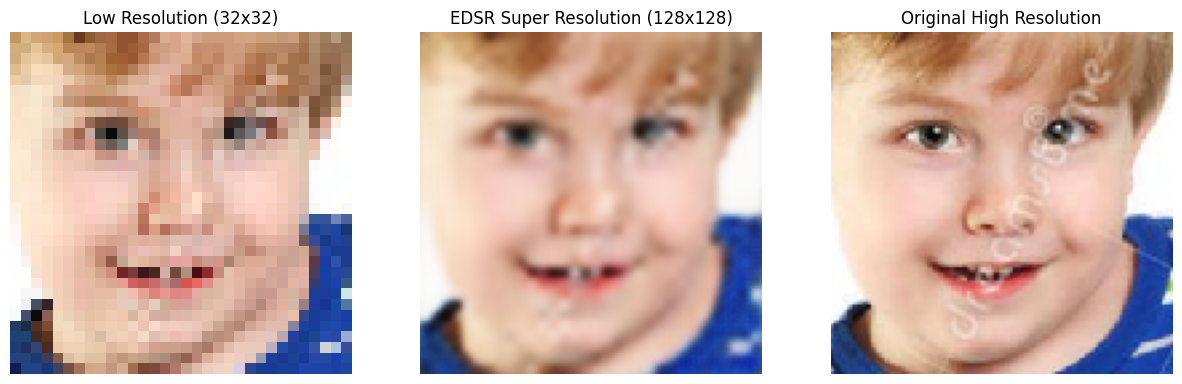

In [29]:
# Visualize results
index = 0
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Low Resolution (32x32)")
plt.imshow(X_test_lr[index])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("EDSR Super Resolution (128x128)")
plt.imshow(X_test_upscaled[index])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Original High Resolution")
plt.imshow(y_test_hr[index])
plt.axis('off')
plt.show()

In [30]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train_upscaled)

In [31]:
def create_regression_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    
    predicted_age = Dense(1, activation='linear', name='age_out')(x)
    return Model(inputs=inputs, outputs=predicted_age)

regression_model = create_regression_model((128, 128, 3))

In [32]:
regression_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [33]:
# Callbacks
model_save_path = '/kaggle/working/edsr_regression_model.keras'
regression_model.save(model_save_path)

checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [34]:
history_regression = regression_model.fit(
    datagen.flow(X_train_upscaled, age_labels_train, batch_size=32),
    validation_data=(X_val_upscaled, age_labels_val),
    epochs=100,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 71s 112ms/step - loss: 453.5691 - mae: 16.2707 - val_loss: 281.5287 - val_mae: 12.7997 - learning_rate: 0.0010
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 63s 106ms/step - loss: 301.2225 - mae: 13.2733 - val_loss: 244.4240 - val_mae: 11.9085 - learning_rate: 0.0010
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - loss: 280.3362 - mae: 12.7090 - val_loss: 225.8905 - val_mae: 10.9186 - learning_rate: 0.0010
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 63s 106ms/step - loss: 238.6317 - mae: 11.6899 - val_loss: 188.9986 - val_mae: 10.5391 - learning_rate: 0.0010
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - loss: 210.7642 - mae: 10.9491 - val_loss: 161.2686 - val_mae: 9.2620 - learning_rate: 0.0010
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - loss: 190.0717 - mae: 10.3665 - val_loss: 152.7885 - val_mae: 8.9413 - learning_rate: 0.0010
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - loss: 183.8441 - mae: 10.2195 - val_loss: 14

In [35]:
model = tf.keras.models.load_model('/kaggle/working/edsr_regression_model.keras')

In [36]:
y_pred = model.predict(X_test_upscaled, verbose=1)

mse = mean_squared_error(age_labels_test, y_pred)
mae = mean_absolute_error(age_labels_test, y_pred)
r2 = r2_score(age_labels_test, y_pred)

print(f"Regression Mean Squared Error (MSE): {mse:.4f}")
print(f"Regression Mean Absolute Error (MAE): {mae:.4f}")
print(f"Regression R² Score: {r2:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Regression Mean Squared Error (MSE): 90.4205
Regression Mean Absolute Error (MAE): 6.9240
Regression R² Score: 0.7677


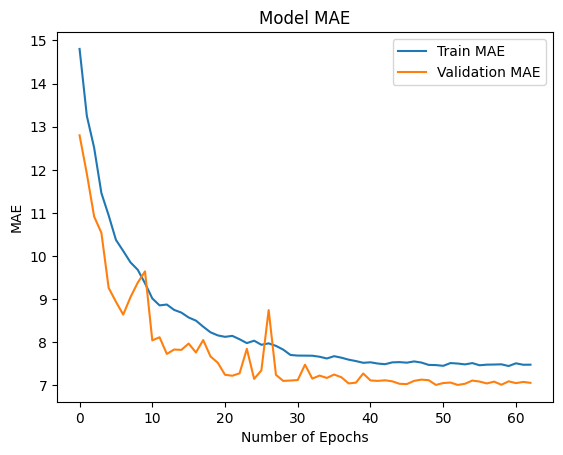

In [37]:
# Plot MAE
plt.plot(history_regression.history['mae'], label='Train MAE')
plt.plot(history_regression.history['val_mae'], label='Validation MAE')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('MAE')
plt.title('Model MAE')
plt.show()

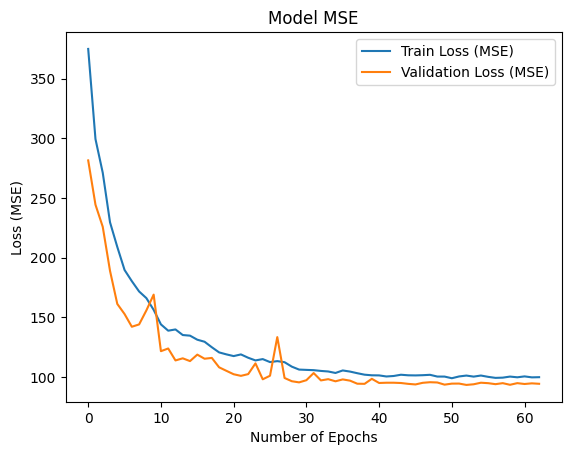

In [38]:
# Plot Loss (MSE)
plt.plot(history_regression.history['loss'], label='Train Loss (MSE)')
plt.plot(history_regression.history['val_loss'], label='Validation Loss (MSE)')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model MSE')
plt.show()